# ResNet Improved for CIFAR-10 Classififcation
* Author: Ziad Tamim
* Description: Training ResNet with CIFAR-10 Dataset and improving accuracy by using data augmentation, L2 regularization, Learning Rate Scheduler and Early Stopping. Loading data, building the Lenet achetiture using tensorflow, training the model, and evaluating its performance.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping


2024-04-30 14:27:20.724832: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 14:27:20.724958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 14:27:20.841461: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading Training and testing data (CIFAR-10)
* Loading the data and splitting it into tarining and testing
* Normalising pixle values
* Resizing images [64 X 64]
* Define L2 regularization

In [2]:
# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Resize images to 64x64 to better fit the model architecture
x_train = tf.image.resize(x_train, [64, 64])
x_test = tf.image.resize(x_test, [64, 64])

# Flatten labels for compatibility with loss function
y_train = y_train.flatten()
y_test = y_test.flatten()

# Define L2 regularization
l2_reg = regularizers.l2(1e-4)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


## Building the ResNet architechture using tensorflow

In [ ]:
def resnet_block(input_layer, filters, conv_size, reduce=False, l2_reg=l2_reg):
    strides = (1, 1)
    if reduce:
        strides = (2, 2)

    # First component of main path
    x = layers.Conv2D(filters, conv_size, padding='same', strides=strides,
                      activation='relu', kernel_initializer='he_normal',
                      kernel_regularizer=l2_reg)(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, conv_size, padding='same', activation=None,
                      kernel_initializer='he_normal', kernel_regularizer=l2_reg)(x)
    x = layers.BatchNormalization()(x)

    # Shortcut path
    if reduce:
        input_layer = layers.Conv2D(filters, (1, 1), strides=strides, padding='same',
                                    activation=None, kernel_initializer='he_normal',
                                    kernel_regularizer=l2_reg)(input_layer)
        input_layer = layers.BatchNormalization()(input_layer)

    x = layers.add([x, input_layer])
    x = layers.Activation('relu')(x)
    return x

def build_resnet(input_shape, l2_reg):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu',
                      kernel_initializer='he_normal', kernel_regularizer=l2_reg)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    num_filters = 64
    for stack in range(3):  # Total 3 stacks
        for res_block in range(3):  # 3 res blocks per stack
            x = resnet_block(x, num_filters, (3, 3), reduce=res_block == 0 and stack > 0, l2_reg=l2_reg)
        num_filters *= 2

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and compile the ResNet model
model = build_resnet((64, 64, 3), l2_reg)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 16, 16,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 16, 16,    │          0 │ add_1[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │     36,928 │ activation_1[0][

 Total params: 4,410,634 (16.83 MB)

 Trainable params: 4,404,362 (16.80 MB)

## Data augmentation/Learning Rate Schedular/Early Stopping

In [4]:
# Data augmentation
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

# Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return float(lr * np.exp(-0.1))

lr_callback = LearningRateScheduler(lr_scheduler)

# Early Stopping
es_callback = EarlyStopping(monitor='val_accuracy', patience=10)


# Training the model
* 40 epochs
* 64 batch size
* Learning Rate callback

In [5]:
# Train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=40, 
                    validation_data=(x_test, y_test), callbacks=[lr_callback, es_callback])

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  3/782 ━━━━━━━━━━━━━━━━━━━━ 51s 66ms/step - accuracy: 0.1250 - loss: 3.7423   

I0000 00:00:1714487298.384832     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 ━━━━━━━━━━━━━━━━━━━━ 124s 121ms/step - accuracy: 0.3626 - loss: 2.3918 - val_accuracy: 0.4876 - val_loss: 1.9750 - learning_rate: 0.0010
Epoch 2/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 75s 95ms/step - accuracy: 0.5500 - loss: 1.7405 - val_accuracy: 0.5749 - val_loss: 1.5731 - learning_rate: 0.0010
Epoch 3/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 75s 95ms/step - accuracy: 0.6390 - loss: 1.4318 - val_accuracy: 0.4726 - val_loss: 2.0455 - learning_rate: 0.0010
Epoch 4/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 75s 95ms/step - accuracy: 0.6940 - loss: 1.2535 - val_accuracy: 0.6536 - val_loss: 1.3077 - learning_rate: 0.0010
Epoch 5/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 75s 95ms/step - accuracy: 0.7262 - loss: 1.1515 - val_accuracy: 0.6531 - val_loss: 1.3538 - learning_rate: 0.0010
Epoch 6/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 75s 95ms/step - accuracy: 0.7455 - loss: 1.0797 - val_accuracy: 0.6377 - val_loss: 1.3674 - learning_rate: 0.0010
Epoch 7/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 75s 95ms/step - accuracy: 0.7684 - loss: 1.00

## Visualising Training Accuracy and Loss

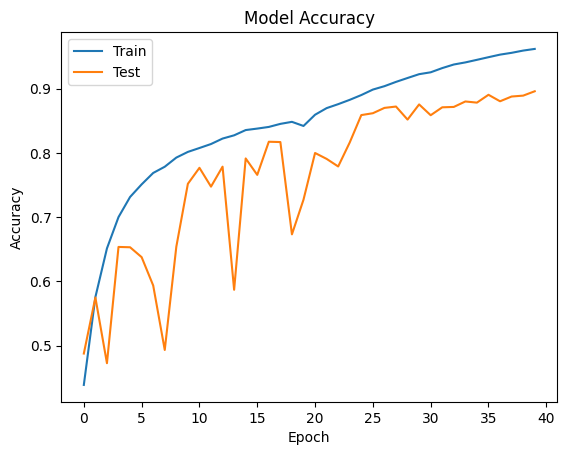

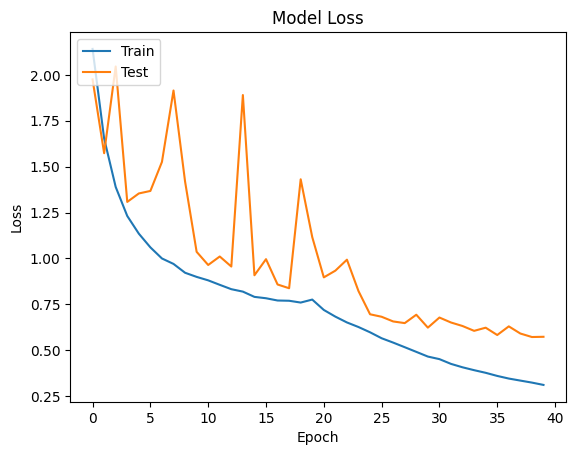

In [9]:
import matplotlib.pyplot as plt
# Plotting the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plotting the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


## Evaluaing the model using confusion matrix and classification report

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


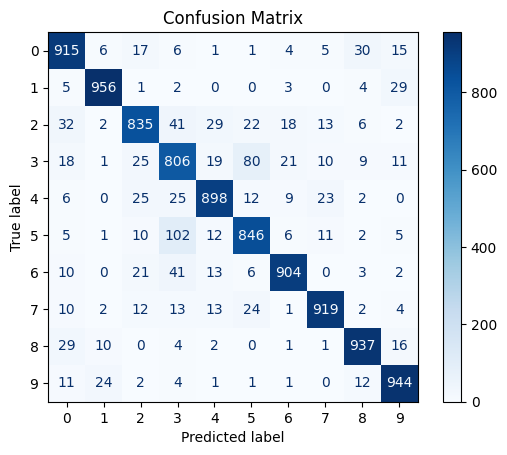

Classification Report:
               precision    recall  f1-score   support

           0     0.8790    0.9150    0.8966      1000
           1     0.9541    0.9560    0.9550      1000
           2     0.8808    0.8350    0.8573      1000
           3     0.7720    0.8060    0.7886      1000
           4     0.9089    0.8980    0.9034      1000
           5     0.8528    0.8460    0.8494      1000
           6     0.9339    0.9040    0.9187      1000
           7     0.9358    0.9190    0.9273      1000
           8     0.9305    0.9370    0.9337      1000
           9     0.9183    0.9440    0.9310      1000

    accuracy                         0.8960     10000
   macro avg     0.8966    0.8960    0.8961     10000
weighted avg     0.8966    0.8960    0.8961     10000



In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
# Predictions for the test set
prediction_scores = model.predict(x_test)
predicted_labels = np.argmax(prediction_scores, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(y_test, predicted_labels, digits=4)
print('Classification Report:\n', report)


## Predicting an image lable from the test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


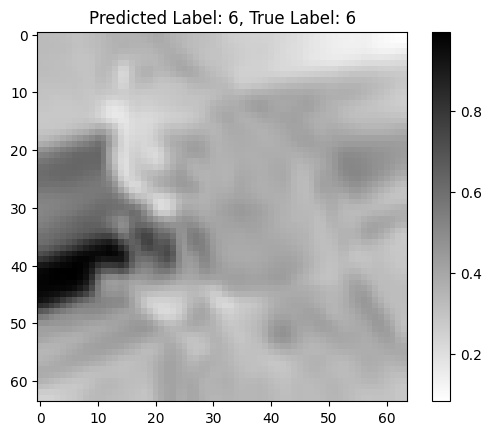

In [11]:
# Inference on a single image
img_index = 7
selected_image = x_test[img_index]
selected_label = y_test[img_index]
image_for_inference = np.expand_dims(selected_image, 0)
predictions = model.predict(image_for_inference)
predicted_label = np.argmax(predictions)

# Display the image
plt.figure()
plt.imshow(selected_image[:, :, 0], cmap=plt.cm.binary)
plt.title(f'Predicted Label: {predicted_label}, True Label: {selected_label}')
plt.colorbar()
plt.grid(False)
plt.show()